# Libraries

In [1]:
import os
import time
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from pyflim import data
import pyift.pyift as ift
from pyflim import layers
from skimage import measure
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from torchvision import tv_tensors
import torchvision.transforms.v2 as T
from torch.utils.data import DataLoader
from scipy.spatial.distance import cdist
from skimage.filters import threshold_otsu
from PIL import Image, ImageOps, ImageDraw, ImageFilter
from skimage.morphology import binary_dilation, binary_erosion, disk

torch.manual_seed(123)
rng = np.random.default_rng(2021)

# Configuration

In [2]:
split = 3
home = "/home/kris/projects/mo445-analise-de-imagem/tarefa_2"
orig_folder = f"{home}/datasets/schisto/images/"
label_folder= f"{home}/datasets/schisto/truelabels/"
marker_folder = f"{home}/data/schisto/split{split}/markers/"
train_split_file = f"{home}/data/schisto/split{split}/train{split}.csv"
test_split_file = f"{home}/data/schisto/split{split}/test{split}.csv"

lr=1e-3
wd=1e-4
device = 'cuda:0'
epochs = 100
lr_gamma = 0.97

In [3]:
import io
import os
import pickle
from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.linear_model import LogisticRegression
import torch
import torchvision.transforms.functional as TF
from tqdm import tqdm
import pyrootutils
from torch import nn

root = pyrootutils.setup_root(
    search_from=Path.cwd().parent,
    indicator=".project-root",
    pythonpath=True,
    dotenv=True,
)

from src.data_modules.schisto import SchistoDataModule

DINOV3_GITHUB_LOCATION = "facebookresearch/dinov3"

if os.getenv("DINOV3_LOCATION") is not None:
    DINOV3_LOCATION = os.getenv("DINOV3_LOCATION")
else:
    DINOV3_LOCATION = DINOV3_GITHUB_LOCATION

print(f"DINOv3 location set to {DINOV3_LOCATION}")

DINOv3 location set to facebookresearch/dinov3


In [4]:
MODEL_DINOV3_VITS = "dinov3_vits16"
MODEL_DINOV3_VITSP = "dinov3_vits16plus"
MODEL_DINOV3_VITB = "dinov3_vitb16"
MODEL_DINOV3_VITL = "dinov3_vitl16"
MODEL_DINOV3_VITHP = "dinov3_vith16plus"
MODEL_DINOV3_VIT7B = "dinov3_vit7b16"

# MODEL_NAME = MODEL_DINOV3_VITL
# MODEL_NAME = MODEL_DINOV3_VITB
MODEL_NAME = MODEL_DINOV3_VITS
FEAT_LAYER = -1

USE_GRAPH_ESTIMATOR = False
IMAGE_SIZE = 400
PATCH_SIZE = 16
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

MODEL_TO_NUM_LAYERS = {
    MODEL_DINOV3_VITS: 12,
    MODEL_DINOV3_VITSP: 12,
    MODEL_DINOV3_VITB: 12,
    MODEL_DINOV3_VITL: 24,
    MODEL_DINOV3_VITHP: 32,
    MODEL_DINOV3_VIT7B: 40,
}

n_layers = MODEL_TO_NUM_LAYERS[MODEL_NAME]


WEIGHTS_MAP = {
    MODEL_DINOV3_VITS: "../checkpoints/dinov3/dinov3_vits16_pretrain_lvd1689m-08c60483.pth",
    MODEL_DINOV3_VITL: "../checkpoints/dinov3/dinov3_vitl16_pretrain_lvd1689m-8aa4cbdd.pth",
    MODEL_DINOV3_VITB: "../checkpoints/dinov3/dinov3_vitb16_pretrain_lvd1689m-73cec8be.pth"
}

model = torch.hub.load(
    repo_or_dir=DINOV3_LOCATION,
    model=MODEL_NAME,
    source="local" if DINOV3_LOCATION != DINOV3_GITHUB_LOCATION else "github",
    weights=WEIGHTS_MAP[MODEL_NAME],
)
model.cuda()

# Assume you have already loaded the model
if USE_GRAPH_ESTIMATOR:
    old_proj = model.patch_embed.proj

    # Create a new Conv2d layer for 8 channels
    new_proj = nn.Conv2d(
        in_channels=8,
        out_channels=old_proj.out_channels,
        kernel_size=old_proj.kernel_size,
        stride=old_proj.stride,
        padding=old_proj.padding,
        bias=old_proj.bias is not None,
    )

    with torch.no_grad():
        # Copy weights according to your mapping
        # Mapping: [R, G, B, R, G, B, R, G]
        new_proj.weight[:, 0, :, :] = old_proj.weight[:, 0, :, :]  # R
        new_proj.weight[:, 1, :, :] = old_proj.weight[:, 1, :, :]  # G
        new_proj.weight[:, 2, :, :] = old_proj.weight[:, 2, :, :]  # B
        new_proj.weight[:, 3, :, :] = old_proj.weight[:, 0, :, :]  # R
        new_proj.weight[:, 4, :, :] = old_proj.weight[:, 1, :, :]  # G
        new_proj.weight[:, 5, :, :] = old_proj.weight[:, 2, :, :]  # B
        new_proj.weight[:, 6, :, :] = old_proj.weight[:, 0, :, :]  # R
        new_proj.weight[:, 7, :, :] = old_proj.weight[:, 1, :, :]  # G

        # Copy bias if it exists
        if old_proj.bias is not None:
            new_proj.bias.copy_(old_proj.bias)

    # Replace the old projection with the new one
    model.patch_embed.proj = new_proj
model.cuda()

classifier_path = "fg_classifier.pkl"
with open(classifier_path, "rb") as f:
    clf = pickle.load(f)

Using cache found in /home/kris/.cache/torch/hub/facebookresearch_dinov3_main


In [5]:
# Quantization filter for the given patch size
patch_quant_filter = torch.nn.Conv2d(
    1, 1, PATCH_SIZE, stride=PATCH_SIZE, bias=False
)
patch_quant_filter.weight.data.fill_(1.0 / (PATCH_SIZE * PATCH_SIZE))

def lab_to_rgb_tensor(lab_image: torch.Tensor) -> torch.Tensor:
    """Convert LAB tensor to RGB tensor.
    
    Args:
        lab_image: Tensor of shape (C, H, W) or (B, C, H, W) in LAB format
    
    Returns:
        RGB tensor in the same shape, normalized to [0, 1]
    """
    # Handle batch dimension
    squeeze_dim = False
    if lab_image.ndim == 3:
        lab_image = lab_image.unsqueeze(0)
        squeeze_dim = True
    
    batch_size = lab_image.shape[0]
    rgb_batch = []
    
    for i in range(batch_size):
        # Convert to numpy (H, W, C)
        lab_np = lab_image[i].permute(1, 2, 0).cpu().numpy()
        # Convert LAB to RGB using OpenCV
        rgb_np = cv2.cvtColor(lab_np, cv2.COLOR_LAB2RGB)
        # Convert back to tensor and normalize to [0, 1]
        rgb_tensor = torch.from_numpy(rgb_np).float()
        rgb_batch.append(rgb_tensor.permute(2, 0, 1))
    
    result = torch.stack(rgb_batch)
    return result.squeeze(0) if squeeze_dim else result

In [82]:
import numpy as np
import torch
import cv2
import torch.nn.functional as F
from tqdm import tqdm
import torchvision.transforms.functional as TF
from scipy import ndimage as ndi
import random
import pyift.pyift as ift
import shutil
from skimage.morphology import disk, binary_erosion, binary_dilation

threshold = 0.4
dice_scores = []
sensitivity_scores = []
specificity_scores = []
f_beta_scores = []

def process_item(item, use_fg_score=False):
    image = item["image"][0]
    mask = item["label"][0]
    item_id = Path(item['image_path'][0]).stem

    test_mask = mask.unsqueeze(0)
    
    test_mask = TF.resize(test_mask, [IMAGE_SIZE, IMAGE_SIZE]).squeeze(0).squeeze(0)
    test_image_rgb = lab_to_rgb_tensor(image)
    test_image_rgb = TF.resize(test_image_rgb, [IMAGE_SIZE, IMAGE_SIZE]).squeeze(0)
    test_image_normalized = TF.normalize(test_image_rgb, mean=IMAGENET_MEAN, std=IMAGENET_STD)

    with torch.inference_mode():
        with torch.autocast(device_type="cuda", dtype=torch.float32):
            feats = model.get_intermediate_layers(
                test_image_normalized.unsqueeze(0).cuda(), n=range(n_layers),
                reshape=True, norm=True
            )
            x = feats[FEAT_LAYER].squeeze().detach().cpu()

    dim = x.shape[0]
    x = x.view(dim, -1).permute(1, 0)
    h_patches = test_image_rgb.shape[1] // PATCH_SIZE
    w_patches = test_image_rgb.shape[2] // PATCH_SIZE

    fg_score = clf.predict_proba(x)[:, 1].reshape(h_patches, w_patches)
    # smooth fg_score
    
    fg_score = cv2.resize(fg_score, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_LINEAR)
    
    # apply median filter
    # fg_score = cv2.medianBlur((fg_score * 255).astype(np.uint8), 13).astype(np.float32) / 255.0
    
    fg_score_bin = (fg_score >= threshold).astype(np.uint8)

    # Connected components
    num_labels, labels_im = cv2.connectedComponents(fg_score_bin)
    best_label = 0
    max_fg_score_sum = 0

    for label in range(1, num_labels):
        component_mask = (labels_im == label)
        if (component_mask[0, :].any() and component_mask[-1, :].any() and
                component_mask[:, 0].any() and component_mask[:, -1].any()):
            continue
        if component_mask.sum() < 400:
            continue
        fg_score_sum = fg_score[component_mask].sum()
        if fg_score_sum > max_fg_score_sum:
            max_fg_score_sum = fg_score_sum
            best_label = label

    gt_mask = (test_mask.numpy() > 0).astype(np.uint8)
    
    if best_label == 0:
        return np.zeros_like(gt_mask, dtype=np.uint8)
    
    pred_mask = (labels_im == best_label).astype(np.uint8)
    
    # 1. Dilate main object generously
    dilate_radius = 80  # tune this; for 256x256 images, 30–60 works well
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (dilate_radius, dilate_radius))
    dilated_mask = cv2.dilate(pred_mask, kernel)

    # 2. Apply a relaxed threshold to FG scores
    low_thresh = 0.25
    fg_low = (fg_score >= low_thresh).astype(np.uint8)

    # 3. Keep only parts of the low-threshold map that lie within the dilated region
    expanded_mask = cv2.bitwise_and(fg_low, dilated_mask)

    # Optional: keep the connected component overlapping the original object the most
    num_labels, labels = cv2.connectedComponents(expanded_mask)
    best_overlap_label = 0
    max_overlap = 0
    for lbl in range(1, num_labels):
        comp = (labels == lbl)
        overlap = np.sum(comp & pred_mask)
        if overlap > max_overlap:
            max_overlap = overlap
            best_overlap_label = lbl
    pred_mask = (labels == best_overlap_label).astype(np.uint8)
    
    # filter fg_score using the final pred_mask
    if use_fg_score:
        return fg_score * pred_mask
    else:
        return pred_mask

# Data

Create the necessary datasets

In [7]:
images_list_flim_training = [i.replace("-seeds.txt", "") for i in os.listdir(marker_folder)]

images_list_gwe_training_ = list(pd.read_csv(train_split_file, header=None)[0])
images_list_gwe_training_ = [i.replace('images/', '').replace('.png', '') for i in images_list_gwe_training_ 
                            if i not in images_list_flim_training and np.array(Image.open(label_folder+i.replace('images/', ''))).max() > 0]

# this can be used for train the graph weight estimator with more images from trainN.csv
p = 0.5
len_ = len(images_list_gwe_training_)
images_list_gwe_training = images_list_gwe_training_[:int(p*len_)]
images_list_gwe_val = images_list_gwe_training_[int(p*len_):]

images_list_gwe_test_ = list(pd.read_csv(test_split_file, header=None)[0])
images_list_gwe_test = [i.replace('images/', '').replace('.png', '') for i in images_list_gwe_test_]

print('Nº Images for FLIM training:', len(images_list_flim_training))
print('Nº Images for GWE training:', len(images_list_gwe_training))
print('Nº Images for GWE validation:', len(images_list_gwe_val))
print('Nº Images for GWE test:', len(images_list_gwe_test))

train_dataset_flim_ = data.FLIMData(orig_folder=orig_folder, marker_folder=marker_folder, 
                                images_list=images_list_flim_training, label_folder=label_folder,
                                orig_ext=".png", marker_ext="-seeds.txt", label_ext=".png",
                                lab_norm=False)

train_dataset_gwe_ = data.FLIMData(orig_folder=orig_folder, images_list=images_list_gwe_training, 
                                  label_folder=label_folder, orig_ext=".png",label_ext=".png",
                                lab_norm=False)

val_dataset_gwe = data.FLIMData(orig_folder=orig_folder, images_list=images_list_gwe_val, 
                                  label_folder=label_folder, orig_ext=".png",label_ext=".png",
                                lab_norm=False)

test_dataset_gwe_ = data.FLIMData(orig_folder=orig_folder, images_list=images_list_gwe_test, 
                                  label_folder=label_folder, orig_ext=".png",label_ext=".png",
                                lab_norm=False)

train_dataset_gwe = DataLoader(train_dataset_gwe_, batch_size=1, shuffle=True) #train dataset for more than 3-4 images(not used yet)
train_dataset_flim = DataLoader(train_dataset_flim_, batch_size=1, shuffle=True) #train dataset with 3-4 images
test_dataset_gwe = DataLoader(test_dataset_gwe_, batch_size=1, shuffle=True) #test dataset

Nº Images for FLIM training: 4
Nº Images for GWE training: 163
Nº Images for GWE validation: 163
Nº Images for GWE test: 610


# Utils

In [8]:
#Filter components by area
def filter_component_by_area(saliency, area_range=[1800,10000]):
    bin_sal = np.copy(saliency)
    thresh = threshold_otsu(saliency)
    bin_sal[saliency>thresh] = 1
    bin_sal[saliency<=thresh] = 0
    saliency[bin_sal == 0] = 0
    sal_components_image = measure.label(bin_sal, background=0, connectivity=2)
    sal_nb_components = sal_components_image.max()
    
    bbs = []
    for c_ in range(1,sal_nb_components+1):
        area = len(sal_components_image[sal_components_image == c_])
        
        if (area < area_range[0] or area > area_range[1]):
            saliency[sal_components_image == c_] = 0
                
    return saliency
#select random pixels on binary images
def random_select(mask, percentage=0.3):
    mask = mask.astype(bool)
    
    indices = np.flatnonzero(mask)
    
    num_select = int(len(indices) * percentage)
    selected = rng.choice(indices, num_select, replace=False)
    
    new_mask = np.zeros_like(mask, dtype=np.uint8)
    new_mask.flat[selected] = 1
    return new_mask

def dice_score(true, pred):
        true = np.copy(true)
        pred = np.copy(pred)
        true[true > 0] = 1
        pred[pred > 0] = 1
        inter = true * pred
        denom = true + pred
        if(true.sum() == 0 and pred.sum() > 0):
            return 0.0
        elif(true.sum() > 0 and pred.sum() == 0):
            return 0.0
        elif(true.sum() == 0 and pred.sum() == 0):
            return 1.0
        return 2.0 * np.sum(inter) / np.sum(denom)

def f_beta_score(pred, gt, beta2=0.3, threshold=0.5):
    # Binarize prediction
    pred_bin = (pred >= threshold).astype(np.uint8)

    if(pred.max()==0 and gt.max()==0):
        return 1.0

    TP = np.sum((pred_bin == 1) & (gt == 1))
    FP = np.sum((pred_bin == 1) & (gt == 0))
    FN = np.sum((pred_bin == 0) & (gt == 1))

    if TP == 0:
        return 0.0
    
    precision = TP / (TP + FP + 1e-8)
    recall    = TP / (TP + FN + 1e-8)

    f_beta = ((1 + beta2) * precision * recall) / (beta2 * precision + recall + 1e-8)
    return float(f_beta)

def labnorm(image):
    new_image = torch.empty_like(image, dtype=image.dtype)

    new_image[:,0, :, :] = image[:,0, :, :] / 99.998337
    new_image[:,1, :, :] = (image[:,1, :, :] + 86.182236) / (86.182236 + 98.258614)
    new_image[:,2, :, :] = (image[:,2, :, :] + 107.867744) / (107.867744 + 94.481682)

    return new_image

def draw_borders(img, mask, edge_width=1, color='magenta'):
    if mask.max() == 1:
        mask = mask * 255
    mask = Image.fromarray(mask).convert("L")

    edges = mask.filter(ImageFilter.FIND_EDGES)

    if edge_width > 1:
        size = 2 * edge_width + 1
        edges = edges.filter(ImageFilter.MaxFilter(size=size))

    edges_rgb = ImageOps.colorize(edges.convert('L'), black='black', white=color)

    img = img.copy()
    img.paste(edges_rgb, mask=edges)

    return img


# Graph estimator network

In [9]:
class GraphWeightEstimator(nn.Module):
    def __init__(self, original_size=(400, 400), embed_dim=8, kernel_size=11, dilation=1):
        super().__init__()
        self.original_size = original_size
        self.kernel_size = kernel_size
        self.dilation = dilation
        self.embed_dim = embed_dim
        
        # Effective kernel size accounting for dilation
        effective_kernel = dilation * (kernel_size - 1) + 1
        
        # Adjust padding to keep the same spatial size
        self.padding = (effective_kernel - 1) // 2

        self.unfold = nn.Unfold(
            kernel_size=self.kernel_size,
            padding=self.padding,
            stride=1,
            dilation=self.dilation
        )
        
        self.fold = nn.Fold(
            output_size=self.original_size,
            kernel_size=1,
            padding=0,
            stride=1
        )

        self.fc = nn.Sequential(
            nn.Linear(3 * kernel_size * kernel_size, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, self.embed_dim)
        )
        
    def forward(self, x):
        # x: (B, 3, H, W)
        x = self.unfold(x)                  # (B, C*k*k, H*W)
        y = self.fc(x.permute(0, 2, 1))     # (B, H*W, embed_dim)
        y = y.permute(0, 2, 1)              # (B, embed_dim, H*W)
        y = self.fold(y)                    # (B, embed_dim, H, W)
        y = y.squeeze(0).permute(1, 2, 0)   # (H, W, embed_dim)
        y = torch.nn.functional.normalize(y, p=2, dim=-1)
        return y

graph_weight_estimator = GraphWeightEstimator(original_size=(400,400), kernel_size=7, embed_dim=8, dilation=1).to(device)
optimizer = torch.optim.Adam(graph_weight_estimator.parameters(), lr=lr, weight_decay=wd)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=lr, max_lr=1e-2,step_size_up=20,mode="exp_range",gamma=lr_gamma)
loss_fn = nn.TripletMarginLoss(margin=0.2)

flim_model = torch.load(f'{home}/models/flim/split{split}/flim_encoder_split{split}.pth', weights_only=False)
# Here you can set any adaptive decoder:
# mean_based_ad
# probability_based_ad
# vanilla_adaptive_decoder
# labeled_marker_d
flim_model.decoder = layers.FLIMAdaptiveDecoderLayer(1,filter_by_size=False, device=device,adj_radius=1.5, decoder_type='mean_based_ad')

# Train

In [10]:
start_time = time.perf_counter()
graph_weight_estimator.train()
best_loss = np.inf
accum_steps=len(train_dataset_flim)
for epoch in range(epochs):
    train_loss = 0
    val_loss = 0
    for i,sample in enumerate(train_dataset_flim):
        x,y,p=sample['image'].cuda(),sample['label'], sample['image_path']
        y[y>0] = 1
        if(y.max() == 0):
            continue
        
        y = y[0].cpu().numpy()

        # representation for each pixel of the image
        representation = graph_weight_estimator(x)
        
        # random subset of data-points
        eroded = binary_erosion(y, footprint=disk(1))
        dilated = binary_dilation(y, footprint=disk(2))
        
        
        training_1 = random_select(eroded, percentage=0.5)
        training_0 = random_select(1-dilated, percentage=0.1)

        seeds_in = training_1.astype(np.int32)
        seeds_out = training_0.astype(np.int32)

        seeds_in_mimg = ift.CreateImageFromNumPy(seeds_in, is3D=False)
        seeds_out_mimg = ift.CreateImageFromNumPy(seeds_out, is3D=False)

        res_mimg = ift.CreateMImageFromNumPy(np.ascontiguousarray(representation.detach().cpu().numpy().astype(np.float32)));

        #(i) propagation of the labels with DT
        res = ift.DynamicTrees(res_mimg, seeds_in_mimg, seeds_out_mimg)        

        res = res.AsNumPy()
        
        #(ii) subsets of correct labeled points of each class (0,1)
        x_correct_1 = np.argwhere((res == 1) & (y == 1))
        x_correct_0 = np.argwhere((res == 0) & (y == 0))

        #balance sizes
        rng.shuffle(x_correct_0)
        x_correct_0 = x_correct_0[:x_correct_1.shape[0], :]

        #shuffle indices
        rng.shuffle(x_correct_1)
        
        #split into two parts
        half = x_correct_1.shape[0] // 2
        anchors_idx  = x_correct_1[:half]
        positives_idx = x_correct_1[half:2*half]

        #extract representations
        anchor_1   = representation[anchors_idx[:,0], anchors_idx[:,1]]
        positive_1 = representation[positives_idx[:,0], positives_idx[:,1]]
        negative_1 = representation[x_correct_0[:half,0], x_correct_0[:half,1]]
        
        loss = loss_fn(anchor_1, positive_1, negative_1)
        
        l2_regularization = 0
        for param in graph_weight_estimator.fc.parameters():
            l2_regularization += torch.norm(param, 2)

        loss += 0.00001 * l2_regularization

        # accumulating the loss for each image to simulate batch
        loss.backward()
        train_loss += loss.item()

        # only optimizes in the last image
        if(i+1)%accum_steps == 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()        

    train_loss = train_loss / len(train_dataset_flim)    
    
    if(train_loss == 0):
        train_loss.append(0)
    if(train_loss < best_loss):
        best_loss = train_loss
        torch.save(graph_weight_estimator, f'{home}/models/estimator_network/best_model_w_flim_triplet_split{split}.pth')
    print('Epoch: ', epoch, 'Loss: ', train_loss,  end="\r")
print('time:', time.perf_counter()-start_time)

time: 102.2630659309979851089413836598


# Test

In [11]:
graph_weight_estimator = torch.load(f'{home}/models/estimator_network/best_model_w_flim_triplet_split{split}.pth', weights_only=False)

In [12]:
def dice_coefficient(pred_bin, gt):
    """Calculate Dice coefficient"""

    if pred_bin.max() == 0 and gt.max() == 0:
        return 1.0

    TP = np.sum((pred_bin == 1) & (gt == 1))
    FP = np.sum((pred_bin == 1) & (gt == 0))
    FN = np.sum((pred_bin == 0) & (gt == 1))

    if TP == 0:
        return 0.0

    dice = (2 * TP) / (2 * TP + FP + FN + 1e-8)
    return float(dice)

def sensitivity(pred_bin, gt):
    """Calculate Sensitivity (Recall)"""

    if pred_bin.max() == 0 and gt.max() == 0:
        return 1.0

    TP = np.sum((pred_bin == 1) & (gt == 1))
    FN = np.sum((pred_bin == 0) & (gt == 1))

    if TP + FN == 0:
        return 0.0

    sensitivity = TP / (TP + FN + 1e-8)
    return float(sensitivity)

def specificity(pred_bin, gt):
    """Calculate Specificity"""

    if pred_bin.max() == 0 and gt.max() == 0:
        return 1.0

    TN = np.sum((pred_bin == 0) & (gt == 0))
    FP = np.sum((pred_bin == 1) & (gt == 0))

    if TN + FP == 0:
        return 0.0

    specificity = TN / (TN + FP + 1e-8)
    return float(specificity)

In [88]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def save_violin_plots(
    fbeta_mlp_scores,
    fbeta_lab_scores,
    sensitivity_mlp_scores,
    sensitivity_lab_scores,
    specificity_mlp_scores,
    specificity_lab_scores,
    dice_mlp_scores,
    dice_lab_scores,
    output_dir="output_violin_plots",
):
    """
    Saves violin plots comparing MLP vs Lab metrics in the specified folder.

    Args:
        fbeta_mlp_scores (list or np.ndarray): F-beta scores for MLP model
        fbeta_lab_scores (list or np.ndarray): F-beta scores for Lab model
        sensitivity_mlp_scores (list or np.ndarray): Sensitivity scores for MLP model
        sensitivity_lab_scores (list or np.ndarray): Sensitivity scores for Lab model
        specificity_mlp_scores (list or np.ndarray): Specificity scores for MLP model
        specificity_lab_scores (list or np.ndarray): Specificity scores for Lab model
        dice_mlp_scores (list or np.ndarray): Dice Coefficient scores for MLP model
        dice_lab_scores (list or np.ndarray): Dice Coefficient scores for Lab model
        output_dir (str): Directory where violin plots will be saved.

    """
    os.makedirs(output_dir, exist_ok=True)

    metrics = {
        "F-beta": (fbeta_mlp_scores, fbeta_lab_scores),
        "Sensitivity": (sensitivity_mlp_scores, sensitivity_lab_scores),
        "Specificity": (specificity_mlp_scores, specificity_lab_scores),
        "Dice": (dice_mlp_scores, dice_lab_scores),
    }

    for metric_name, (mlp_scores, lab_scores) in metrics.items():
        data = {
            "MLP": mlp_scores,
            "Lab": lab_scores
        }

        # Convert to long format for seaborn
        plot_data = []
        model_labels = []
        for model, scores in data.items():
            plot_data.extend(scores)
            model_labels.extend([model] * len(scores))

        # Plot
        plt.figure(figsize=(6, 5))
        sns.violinplot(x=model_labels, y=plot_data, palette="Set2", inner="box")
        plt.title(f"{metric_name} Comparison")
        plt.ylabel(metric_name)
        plt.xlabel("Model Type")
        plt.grid(True, linestyle="--", alpha=0.6)

        # Add mean ± std text
        mean_mlp, std_mlp = np.mean(mlp_scores), np.std(mlp_scores)
        mean_lab, std_lab = np.mean(lab_scores), np.std(lab_scores)
        plt.text(
            -0.25,
            min(plot_data),
            f"MLP: {mean_mlp:.4f} ± {std_mlp:.4f}",
            fontsize=9,
            color="blue",
        )
        plt.text(
            0.75,
            min(plot_data),
            f"Lab: {mean_lab:.4f} ± {std_lab:.4f}",
            fontsize=9,
            color="green",
        )

        # Save figure
        output_path = os.path.join(output_dir, f"{metric_name.lower()}_violin.png")
        plt.tight_layout()
        plt.savefig(output_path, dpi=300)
        plt.close()

        print(f"Saved {metric_name} violin plot → {output_path}")

In [92]:
graph_weight_estimator.eval()
flim_model.eval()
start_time = time.perf_counter()
use_gt = False
USE_FLIM = True
NO_IFT = False #use USE_FLIM = True with NO_IFT = True to use only FLIM model without IFT segmentation

fbeta_mlp_scores = []
fbeta_lab_scores = []

sensitivity_mlp_scores = []
sensitivity_lab_scores = []

specificity_mlp_scores = []
specificity_lab_scores = []

dice_mlp_scores = []
dice_lab_scores = []

with torch.no_grad():    
    for sample in tqdm(test_dataset_gwe):
        x,y=sample['image'].cuda(),sample['label']
        y[y>0] = 1
        y = y[0].cpu().numpy()
        
        representation = graph_weight_estimator(x)

        if(not use_gt):   
            
            if USE_FLIM:
                x_t = labnorm(x)
                y_t = flim_model.forward(x_t, decoder_layer=0)
                y_t = y_t.squeeze().detach().cpu().numpy()
                saliency = ift.CreateImageFromNumPy((y_t).astype(np.int32), is3D=False)
            else:
                y_t = process_item(sample, use_fg_score=True)
                saliency = ift.CreateImageFromNumPy((y_t*255).astype(np.int32), is3D=False)
        else:
            saliency = ift.CreateImageFromNumPy((y*255).astype(np.int32), is3D=False)

        res_mimg = ift.CreateMImageFromNumPy(np.ascontiguousarray(representation.detach().cpu().numpy().astype(np.float32)))
        orig_mimg = ift.CreateMImageFromNumPy(np.ascontiguousarray(x.squeeze().permute((1,2,0)).detach().cpu().numpy().astype(np.float32)))

        # Here we use a method that do pre-processings on the masks before dynamic trees, for details look at iftSegmentation.c
        # Parameters: (mimg, saliency, border, min comp area, max comp area, saliency erosion, saliency dilation)
        if NO_IFT:
            # threshold y_t to create binary masks
            thresh = threshold_otsu(y_t)
            res = (y_t >= thresh).astype(np.uint8)
            res1 = np.copy(res)
        else:
            if(not use_gt):
                res = ift.SMansoniDelineation(res_mimg, saliency, 1, 1000, 9000, 2, 30)       
                res1 = ift.SMansoniDelineation(orig_mimg, saliency, 1, 1000, 9000, 2, 30)
            else:
                res = ift.SMansoniDelineation(res_mimg, saliency, 1, 1000, 9000, 5, 10)       
                res1 = ift.SMansoniDelineation(orig_mimg, saliency, 1, 1000, 9000, 5, 10)
            
            res = res.AsNumPy()
            res1 = res1.AsNumPy()
        
        f_beta_mlp = f_beta_score(y, res)
        f_beta_lab = f_beta_score(y, res1)
        fbeta_mlp_scores.append(f_beta_mlp)
        fbeta_lab_scores.append(f_beta_lab)
        
        y = (y > 0.5).astype(np.uint8)
        sens_mlp = sensitivity(res, y)
        sens_lab = sensitivity(res1, y)
        sensitivity_mlp_scores.append(sens_mlp)
        sensitivity_lab_scores.append(sens_lab)
        
        specificity_mlp = specificity(res, y)
        specificity_lab = specificity(res1, y)
        specificity_mlp_scores.append(specificity_mlp)
        specificity_lab_scores.append(specificity_lab)
        
        dice_mlp = dice_coefficient(res, y)
        dice_lab = dice_coefficient(res1, y)
        dice_mlp_scores.append(dice_mlp)
        dice_lab_scores.append(dice_lab)
        
print('time:', time.perf_counter()-start_time)

# save .npy files with the scores
os.makedirs("results", exist_ok=True)
np.save(f"results/fbeta_mlp_scores_split{split}.npy", np.array(fbeta_mlp_scores))
np.save(f"results/fbeta_lab_scores_split{split}.npy", np.array(fbeta_lab_scores))
np.save(f"results/sensitivity_mlp_scores_split{split}.npy", np.array(sensitivity_mlp_scores))
np.save(f"results/sensitivity_lab_scores_split{split}.npy", np.array(sensitivity_lab_scores))
np.save(f"results/specificity_mlp_scores_split{split}.npy", np.array(specificity_mlp_scores))
np.save(f"results/specificity_lab_scores_split{split}.npy", np.array(specificity_lab_scores))
np.save(f"results/dice_mlp_scores_split{split}.npy", np.array(dice_mlp_scores))
np.save(f"results/dice_lab_scores_split{split}.npy", np.array(dice_lab_scores))


print(f"F-beta MLP: {np.mean(fbeta_mlp_scores):.4f} ± {np.std(fbeta_mlp_scores):.4f} | "
      f"F-beta Lab: {np.mean(fbeta_lab_scores):.4f} ± {np.std(fbeta_lab_scores):.4f}")

print(f"Sensitivity MLP: {np.mean(sensitivity_mlp_scores):.4f} ± {np.std(sensitivity_mlp_scores):.4f} | "
      f"Sensitivity Lab: {np.mean(sensitivity_lab_scores):.4f} ± {np.std(sensitivity_lab_scores):.4f}")

print(f"Specificity MLP: {np.mean(specificity_mlp_scores):.4f} ± {np.std(specificity_mlp_scores):.4f} | "
      f"Specificity Lab: {np.mean(specificity_lab_scores):.4f} ± {np.std(specificity_lab_scores):.4f}")

print(f"Dice MLP: {np.mean(dice_mlp_scores):.4f} ± {np.std(dice_mlp_scores):.4f} | "
      f"Dice Lab: {np.mean(dice_lab_scores):.4f} ± {np.std(dice_lab_scores):.4f}")

100%|██████████| 610/610 [01:35<00:00,  6.39it/s]

time: 95.50435864099927
F-beta MLP: 0.8493 ± 0.2976 | F-beta Lab: 0.8446 ± 0.2886
Sensitivity MLP: 0.8844 ± 0.3046 | Sensitivity Lab: 0.8459 ± 0.2886
Specificity MLP: 0.9927 ± 0.0108 | Specificity Lab: 0.9961 ± 0.0097
Dice MLP: 0.8173 ± 0.2970 | Dice Lab: 0.8466 ± 0.2919


In [14]:
use_gt = False

sample = next(iter(test_dataset_gwe))
x,y = sample['image'].cuda(),sample['label']

while(sample['label'].max() == 0):
    sample = next(iter(test_dataset_gwe))
    x,y = sample['image'].cuda(),sample['label']

representation_ = graph_weight_estimator(x)

y[y>0] = 1
y = y[0].cpu().numpy()

if(not use_gt):
    x_t = labnorm(x)
    y_t = flim_model.forward(x_t, decoder_layer=1)
    y_t = y_t.squeeze().detach().cpu().numpy().astype(np.int32)
    
    y_t_p = y_t.copy()
    th = threshold_otsu(y_t_p)
    y_t_p[y_t_p<th] = 0
    y_t_p[y_t_p>0] = 1
    y_t_p = filter_component_by_area(y_t_p.astype(np.uint8), area_range=[1000,9000])
else:
    eroded = binary_erosion(y, footprint=disk(5)).astype(np.int32)
    dilated = binary_dilation(y, footprint=disk(10)).astype(np.int32)
    y_t_p = eroded

output_image = np.zeros((400, 400))
representation_np = representation_.detach().cpu().numpy()

h,w = output_image.shape
r = 1

dx = representation_np[1:,:,:] - representation_np[:-1,:,:]
dy = representation_np[:,1:,:] - representation_np[:,:-1,:]
grad_x = np.linalg.norm(dx, axis=2)
grad_y = np.linalg.norm(dy, axis=2)
grad = np.zeros((h,w))
grad[:-1,:] += grad_x
grad[:,:-1] += grad_y
output_image = np.sqrt(grad)


if(use_gt):        
    saliency = ift.CreateImageFromNumPy((y*255).astype(np.int32), is3D=False)
else:
    saliency = ift.CreateImageFromNumPy((y_t).astype(np.int32), is3D=False)

seeds_in = random_select(eroded, percentage=0.2).astype(np.int32)
seeds_out = random_select(1-dilated, percentage=0.2).astype(np.int32)
seeds_in_mimg = ift.CreateImageFromNumPy(seeds_in, is3D=False)
seeds_out_mimg = ift.CreateImageFromNumPy(seeds_out, is3D=False)


res_mimg = ift.CreateMImageFromNumPy(np.ascontiguousarray(representation_np.astype(np.float32)))
orig_mimg = ift.CreateMImageFromNumPy(np.ascontiguousarray(x.squeeze().permute((1,2,0)).detach().cpu().numpy().astype(np.float32)))


res = ift.SMansoniDelineation(res_mimg, saliency, 1, 1000, 9000, 2, 30, 1)        
res1 = ift.SMansoniDelineation(orig_mimg, saliency, 1, 1000, 9000, 2, 30, 1)

res_mlp = res.AsNumPy()
res_lab = res1.AsNumPy()

img = Image.open(sample['image_path'][0])
img_gt = draw_borders(img, y, edge_width=1)
img_mlp = draw_borders(img, res_mlp,edge_width=1)
img_mlp = draw_borders(img_mlp, y_t_p, edge_width=1, color='blue')
img_lab = draw_borders(img, res_lab,edge_width=1)
img_lab = draw_borders(img_lab, y_t_p, edge_width=1, color='blue')


fig,ax = plt.subplots(3,2,figsize=(7,13), dpi=300)
ax = ax.flatten()
ax[0].imshow(img_gt)
ax[0].set_title('Ground truth')
ax[1].imshow(output_image, cmap='jet')
ax[1].set_title(f'Gradient')
ax[2].imshow(res_mlp, cmap='gray')
ax[2].set_title(f"MLP + DT, F-score: {f_beta_score(y,res_mlp):.4f}")
ax[3].imshow(res_lab, cmap='gray')
ax[3].set_title(f"LAB + DT, F-score: {f_beta_score(y,res_lab):.4f}")
ax[4].imshow(img_mlp)
ax[5].imshow(img_lab)

TypeError: SMansoniDelineation() takes 7 positional arguments but 8 were given

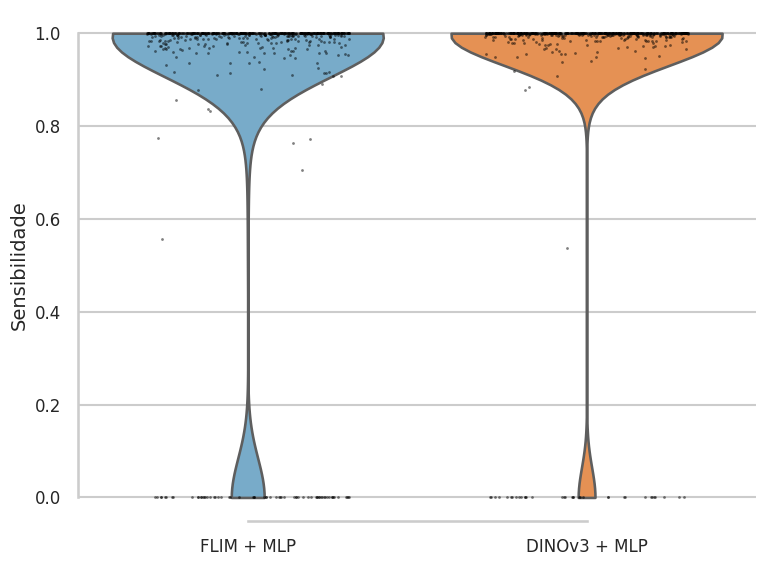

FLIM + MLP - High Sensitivity (>0.8): 541, Low Sensitivity (<0.2): 64
DINOv3 + MLP - High Sensitivity (>0.8): 574, Low Sensitivity (<0.2): 35


In [116]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

# Load scores
flim_scores = np.load("flim_results/sensitivity_mlp_scores_split3.npy").flatten()
dinov3_scores = np.load("dinov3_results/sensitivity_mlp_scores_split3.npy").flatten()

# Combine data
data = pd.DataFrame({
    "Model": ["FLIM + MLP"] * len(flim_scores) + ["DINOv3 + MLP"] * len(dinov3_scores),
    "Sensibilidade": np.concatenate([flim_scores, dinov3_scores]),
})

# Set modern Seaborn theme
sns.set_theme(style="whitegrid", context="talk")

# Plot
plt.figure(figsize=(8, 6))
sns.violinplot(
    data=data,
    x="Model",
    y="Sensibilidade",
    hue="Model",
    palette=["#6baed6", "#fd8d3c"],  # custom blue & orange
    inner=None,
    cut=0,
    legend=False,
)
sns.stripplot(
    data=data,
    x="Model",
    y="Sensibilidade",
    color="black",
    size=2,
    alpha=0.5,
    jitter=0.3,
)

# Titles and labels
# plt.title("Sensitivity Score Distribution — FLIM vs DINOv3", fontsize=16, pad=15)
plt.xlabel("")
plt.ylabel("Sensibilidade", fontsize=14)
plt.ylim(-0.05, 1.05)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.despine(trim=True)

# Tight layout and show
plt.tight_layout()
plt.savefig("sensitivity_violin_plot_flim_vs_dinov3.png", dpi=300)
plt.show()

# print number of images with sensitivity > 0.8 and < 0.2 for each model
flim_high_sens = np.sum(flim_scores > 0.8)
flim_low_sens = np.sum(flim_scores < 0.2)
dinov3_high_sens = np.sum(dinov3_scores > 0.8)
dinov3_low_sens = np.sum(dinov3_scores < 0.2)

print(f"FLIM + MLP - High Sensitivity (>0.8): {flim_high_sens}, Low Sensitivity (<0.2): {flim_low_sens}")
print(f"DINOv3 + MLP - High Sensitivity (>0.8): {dinov3_high_sens}, Low Sensitivity (<0.2): {dinov3_low_sens}")

In [112]:
# get indices of images with low sensitivity for dinov3
dinov3_low_sens_indices = np.where(dinov3_scores < 0.2)[0]
flim_low_sens_indices = np.where(flim_scores < 0.2)[0]

# iterate over the dataloader, and check which indices with low sensitivity have empty ground truth masks
dinov3_low_sens_with_empty_gt = []
flim_low_sens_with_empty_gt = []
for idx, sample in enumerate(test_dataset_gwe):
    if idx in dinov3_low_sens_indices:
        y = sample['label'].cpu().numpy()
        if y.max() == 0:
            dinov3_low_sens_with_empty_gt.append(sample['image_path'][0])
    if idx in flim_low_sens_indices:
        y = sample['label'].cpu().numpy()
        if y.max() == 0:
            flim_low_sens_with_empty_gt.append(sample['image_path'][0])

print(f"Percentage of low sensitivity images with empty ground truth masks for DINOv3 + MLP: {len(dinov3_low_sens_with_empty_gt)}/{len(dinov3_low_sens_indices)}")
print(f"Percentage of low sensitivity images with empty ground truth masks for FLIM + MLP: {len(flim_low_sens_with_empty_gt)}/{len(flim_low_sens_indices)}")


Percentage of low sensitivity images with empty ground truth masks for DINOv3 + MLP: 19/35
Percentage of low sensitivity images with empty ground truth masks for FLIM + MLP: 26/64
